In [5]:
import torch
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tensordict import MemoryMappedTensor

from world_machine.layers.attention import MultiHeadSelfAttention, MultiHeadAttention
from world_machine import WorldMachine
from world_machine_experiments.toy1d import Dimensions

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

In [8]:
batch_size = 32

In [9]:
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base
from hamilton import driver


d = driver.Builder().with_modules(base, shared).build()

inputs = {"sequence_length": 1000,
                       "n_sequence": 10000,
                       "context_size": 200,
                       "batch_size": batch_size,
                       "learning_rate": 5e-4,
                       "weight_decay": 5e-5,
                       "accumulation_steps": 1,
                       "state_dimensions": [0],
                       "device": device,
                       "state_control": "periodic",
                       "seed":[0,42],
                       "train_mse":True,
                       "train_sdtw":False,
                       "sensorial_train_losses": [Dimensions.MEASUREMENT]
                       }

outputs = d.execute(["toy1d_dataloaders", "toy1d_criterion_set"], inputs=inputs)

In [10]:
criterion_set = outputs["toy1d_criterion_set"]

In [11]:
seq_len = 200
state_size = 128


In [12]:
from world_machine.train.stages import StateManager, PrepareModel
from world_machine.train import DatasetPassMode

sm = StateManager()
pm = PrepareModel()

np_generator = np.random.default_rng(0)
torch_generator = torch.Generator(device=device)
torch_generator.manual_seed(0)

for stage in [sm, pm]:
    stage.set_generators(np_generator, torch_generator)

In [13]:
train_loader = outputs["toy1d_dataloaders"]["train"]
val_loader = outputs["toy1d_dataloaders"]["val"]

In [15]:
recompute = False

if recompute:

    pm.pre_batch(model, DatasetPassMode.MODE_EVALUATE, None, None, None, None, None)

    for split in ["train", "val"]:
        dataloader = outputs["toy1d_dataloaders"][split]
        dataset = dataloader.dataset
        for item in tqdm.tqdm(dataloader, desc="State Generation"):
            item = item.to(device)
            
            segments = [item]
            sm.pre_segment(segments, None, batch_size, seq_len, 0, device, state_size, None)

            sensorial_data = item["inputs"]
            state = item["inputs"]["state"]
            logits = model.inference(state=state, sensorial_data=sensorial_data)

            #logits.batch_size = [32]
            item["logits"] = logits

            segments = [item]
            sm.post_segment(segments, None, dataset, 0, None, DatasetPassMode.MODE_EVALUATE, device, None)

    pm.post_batch(model, None, None, None)

else:
    states_shape = [batch_size, seq_len, state_size]

    states_shape[0] = train_loader.dataset._size
    train_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_0.bin", dtype=torch.float32, shape=states_shape)

    states_shape[0] = val_loader.dataset._size
    val_loader.dataset._states = MemoryMappedTensor.from_filename("TempStates_Toy1dDataset_1.bin", dtype=torch.float32, shape=states_shape)

train_loader.dataset.persist_states = True
val_loader.dataset.persist_states = True

In [18]:
from torch.optim import AdamW

from world_machine_experiments.toy1d.base import toy1d_model_training_info
from world_machine_experiments.toy1d.base  import toy1d_metrics, toy1d_metrics_sample_logits, toy1d_metrics_sample_plots, save_toy1d_metrics_sample_plots

In [19]:
dataloaders =  outputs["toy1d_dataloaders"]

In [20]:
del criterion_set.criterions["state_decoded"]["0.1sdtw"]
del criterion_set.criterions["measurement"]["0.1sdtw"]

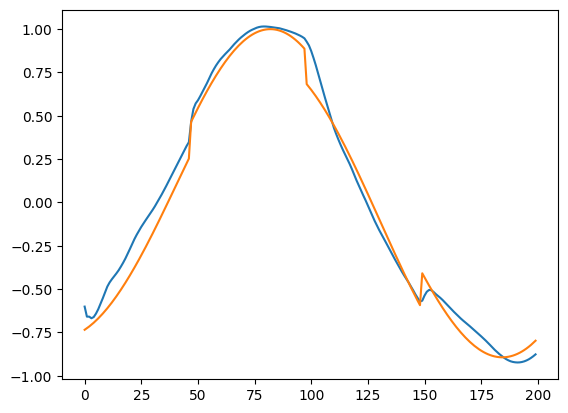

In [21]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

item = next(iter(train_loader))

item = item.to(device)

with torch.no_grad():
    logits = model(item["inputs"]["state"], sensorial_data=item["inputs"])

index = 0
plt.plot(logits["state_decoded"][index,:,0].cpu())
plt.plot(item["inputs"]["state_decoded"][index,:,0].cpu())

In [23]:
from world_machine.train.scheduler import UniformScheduler


In [28]:
model : WorldMachine = torch.load("toy1d_experiments/toy1d_model.pt", weights_only=False, map_location=device)

n_epoch = 20

for module in model.modules():
    if isinstance(module, MultiHeadAttention):
        module.local_only = True
        module.requires_grad_(False)

training_info = toy1d_model_training_info(toy1d_model_untrained=model, 
                                          toy1d_dataloaders=dataloaders, 
                                          toy1d_criterion_set=criterion_set, 
                                          n_epoch=n_epoch,
                                          optimizer_class=AdamW,
                                          learning_rate=5e-6,
                                          weight_decay=5e-7,
                                          device=device,
                                          mask_sensorial_data=UniformScheduler(0, 1, n_epoch),
                                          discover_state=False,
                                          state_dimensions=[0],

                                          #short_time_recall={2},
                                          #recall_stride_future=3,
                                          #recall_stride_past=3,
                                          #recall_n_future=5,
                                          #recall_n_past=5,
                                          #
                                          #noise_config={"state": {"mean": 0.0,"std": 0.1},"measurement": {"mean": 0.0,"std": 0.1}}

                                          )

for module in model.modules():
    if isinstance(module, MultiHeadAttention):
        module.local_only = False
        module.requires_grad_(True)


100%|██████████| 250/250 [00:09<00:00, 25.77it/s]


VAL Epoch [0/20],             Loss: 0.0421


100%|██████████| 750/750 [00:32<00:00, 23.12it/s]


Epoch [1/20],             Loss: 0.0370, Elapsed Time: 32.49 sec


100%|██████████| 250/250 [00:09<00:00, 26.46it/s]


VAL Epoch [1/20],             Loss: 0.0253


100%|██████████| 750/750 [00:32<00:00, 23.18it/s]


Epoch [2/20],             Loss: 0.0281, Elapsed Time: 32.40 sec


100%|██████████| 250/250 [00:09<00:00, 27.17it/s]


VAL Epoch [2/20],             Loss: 0.0210


100%|██████████| 750/750 [00:33<00:00, 22.37it/s]


Epoch [3/20],             Loss: 0.0247, Elapsed Time: 33.58 sec


100%|██████████| 250/250 [00:10<00:00, 23.24it/s]


VAL Epoch [3/20],             Loss: 0.0190


100%|██████████| 750/750 [00:36<00:00, 20.54it/s]


Epoch [4/20],             Loss: 0.0231, Elapsed Time: 36.58 sec


100%|██████████| 250/250 [00:10<00:00, 24.72it/s]


VAL Epoch [4/20],             Loss: 0.0179


100%|██████████| 750/750 [00:36<00:00, 20.82it/s]


Epoch [5/20],             Loss: 0.0222, Elapsed Time: 36.07 sec


100%|██████████| 250/250 [00:09<00:00, 25.41it/s]


VAL Epoch [5/20],             Loss: 0.0173


100%|██████████| 750/750 [00:34<00:00, 21.88it/s]


Epoch [6/20],             Loss: 0.0215, Elapsed Time: 34.33 sec


100%|██████████| 250/250 [00:09<00:00, 25.27it/s]


VAL Epoch [6/20],             Loss: 0.0169


100%|██████████| 750/750 [00:34<00:00, 21.96it/s]


Epoch [7/20],             Loss: 0.0211, Elapsed Time: 34.20 sec


100%|██████████| 250/250 [00:10<00:00, 23.90it/s]


VAL Epoch [7/20],             Loss: 0.0166


100%|██████████| 750/750 [00:32<00:00, 22.76it/s]


Epoch [8/20],             Loss: 0.0208, Elapsed Time: 32.99 sec


100%|██████████| 250/250 [00:09<00:00, 26.75it/s]


VAL Epoch [8/20],             Loss: 0.0163


100%|██████████| 750/750 [00:32<00:00, 23.19it/s]


Epoch [9/20],             Loss: 0.0206, Elapsed Time: 32.39 sec


100%|██████████| 250/250 [00:09<00:00, 26.96it/s]


VAL Epoch [9/20],             Loss: 0.0161


100%|██████████| 750/750 [00:32<00:00, 22.89it/s]


Epoch [10/20],             Loss: 0.0203, Elapsed Time: 32.81 sec


100%|██████████| 250/250 [00:09<00:00, 27.21it/s]


VAL Epoch [10/20],             Loss: 0.0160


100%|██████████| 750/750 [00:32<00:00, 23.20it/s]


Epoch [11/20],             Loss: 0.0201, Elapsed Time: 32.36 sec


100%|██████████| 250/250 [00:09<00:00, 26.90it/s]


VAL Epoch [11/20],             Loss: 0.0158


100%|██████████| 750/750 [00:32<00:00, 23.26it/s]


Epoch [12/20],             Loss: 0.0199, Elapsed Time: 32.28 sec


100%|██████████| 250/250 [00:09<00:00, 26.95it/s]


VAL Epoch [12/20],             Loss: 0.0157


100%|██████████| 750/750 [00:32<00:00, 23.11it/s]


Epoch [13/20],             Loss: 0.0197, Elapsed Time: 32.49 sec


100%|██████████| 250/250 [00:09<00:00, 26.81it/s]


VAL Epoch [13/20],             Loss: 0.0156


100%|██████████| 750/750 [00:32<00:00, 23.03it/s]


Epoch [14/20],             Loss: 0.0196, Elapsed Time: 32.62 sec


100%|██████████| 250/250 [00:09<00:00, 26.81it/s]


VAL Epoch [14/20],             Loss: 0.0155


100%|██████████| 750/750 [00:32<00:00, 23.38it/s]


Epoch [15/20],             Loss: 0.0196, Elapsed Time: 32.12 sec


100%|██████████| 250/250 [00:09<00:00, 26.81it/s]


VAL Epoch [15/20],             Loss: 0.0154


100%|██████████| 750/750 [00:32<00:00, 23.15it/s]


Epoch [16/20],             Loss: 0.0196, Elapsed Time: 32.45 sec


100%|██████████| 250/250 [00:09<00:00, 26.81it/s]


VAL Epoch [16/20],             Loss: 0.0153


100%|██████████| 750/750 [00:32<00:00, 22.99it/s]


Epoch [17/20],             Loss: 0.0195, Elapsed Time: 32.67 sec


100%|██████████| 250/250 [00:09<00:00, 26.90it/s]


VAL Epoch [17/20],             Loss: 0.0153


100%|██████████| 750/750 [00:32<00:00, 23.40it/s]


Epoch [18/20],             Loss: 0.0193, Elapsed Time: 32.10 sec


100%|██████████| 250/250 [00:09<00:00, 26.98it/s]


VAL Epoch [18/20],             Loss: 0.0152


100%|██████████| 750/750 [00:32<00:00, 23.30it/s]


Epoch [19/20],             Loss: 0.0192, Elapsed Time: 32.23 sec


100%|██████████| 250/250 [00:09<00:00, 26.61it/s]


VAL Epoch [19/20],             Loss: 0.0151


100%|██████████| 750/750 [00:33<00:00, 22.42it/s]


Epoch [20/20],             Loss: 0.0192, Elapsed Time: 33.50 sec


100%|██████████| 250/250 [00:09<00:00, 27.01it/s]

VAL Epoch [20/20],             Loss: 0.0151


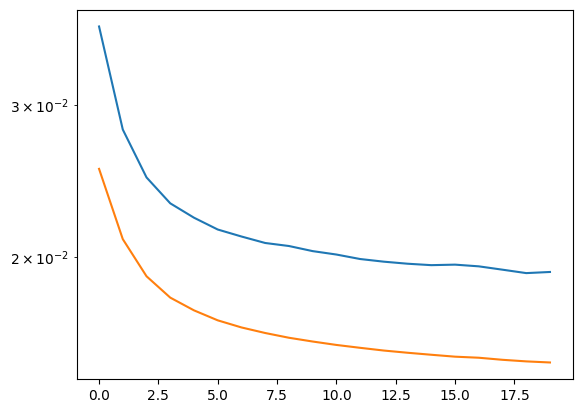

In [29]:
plt.plot(training_info["toy1d_train_history"]["optimizer_loss_train"])
plt.plot(training_info["toy1d_train_history"]["optimizer_loss_val"])

plt.yscale("log")

plt.show()

In [30]:
#metrics = toy1d_metrics(model, outputs["dataloaders"], criterion_set)

sample_logits = toy1d_metrics_sample_logits(model, dataloaders, criterion_set)


Metrics Generation: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


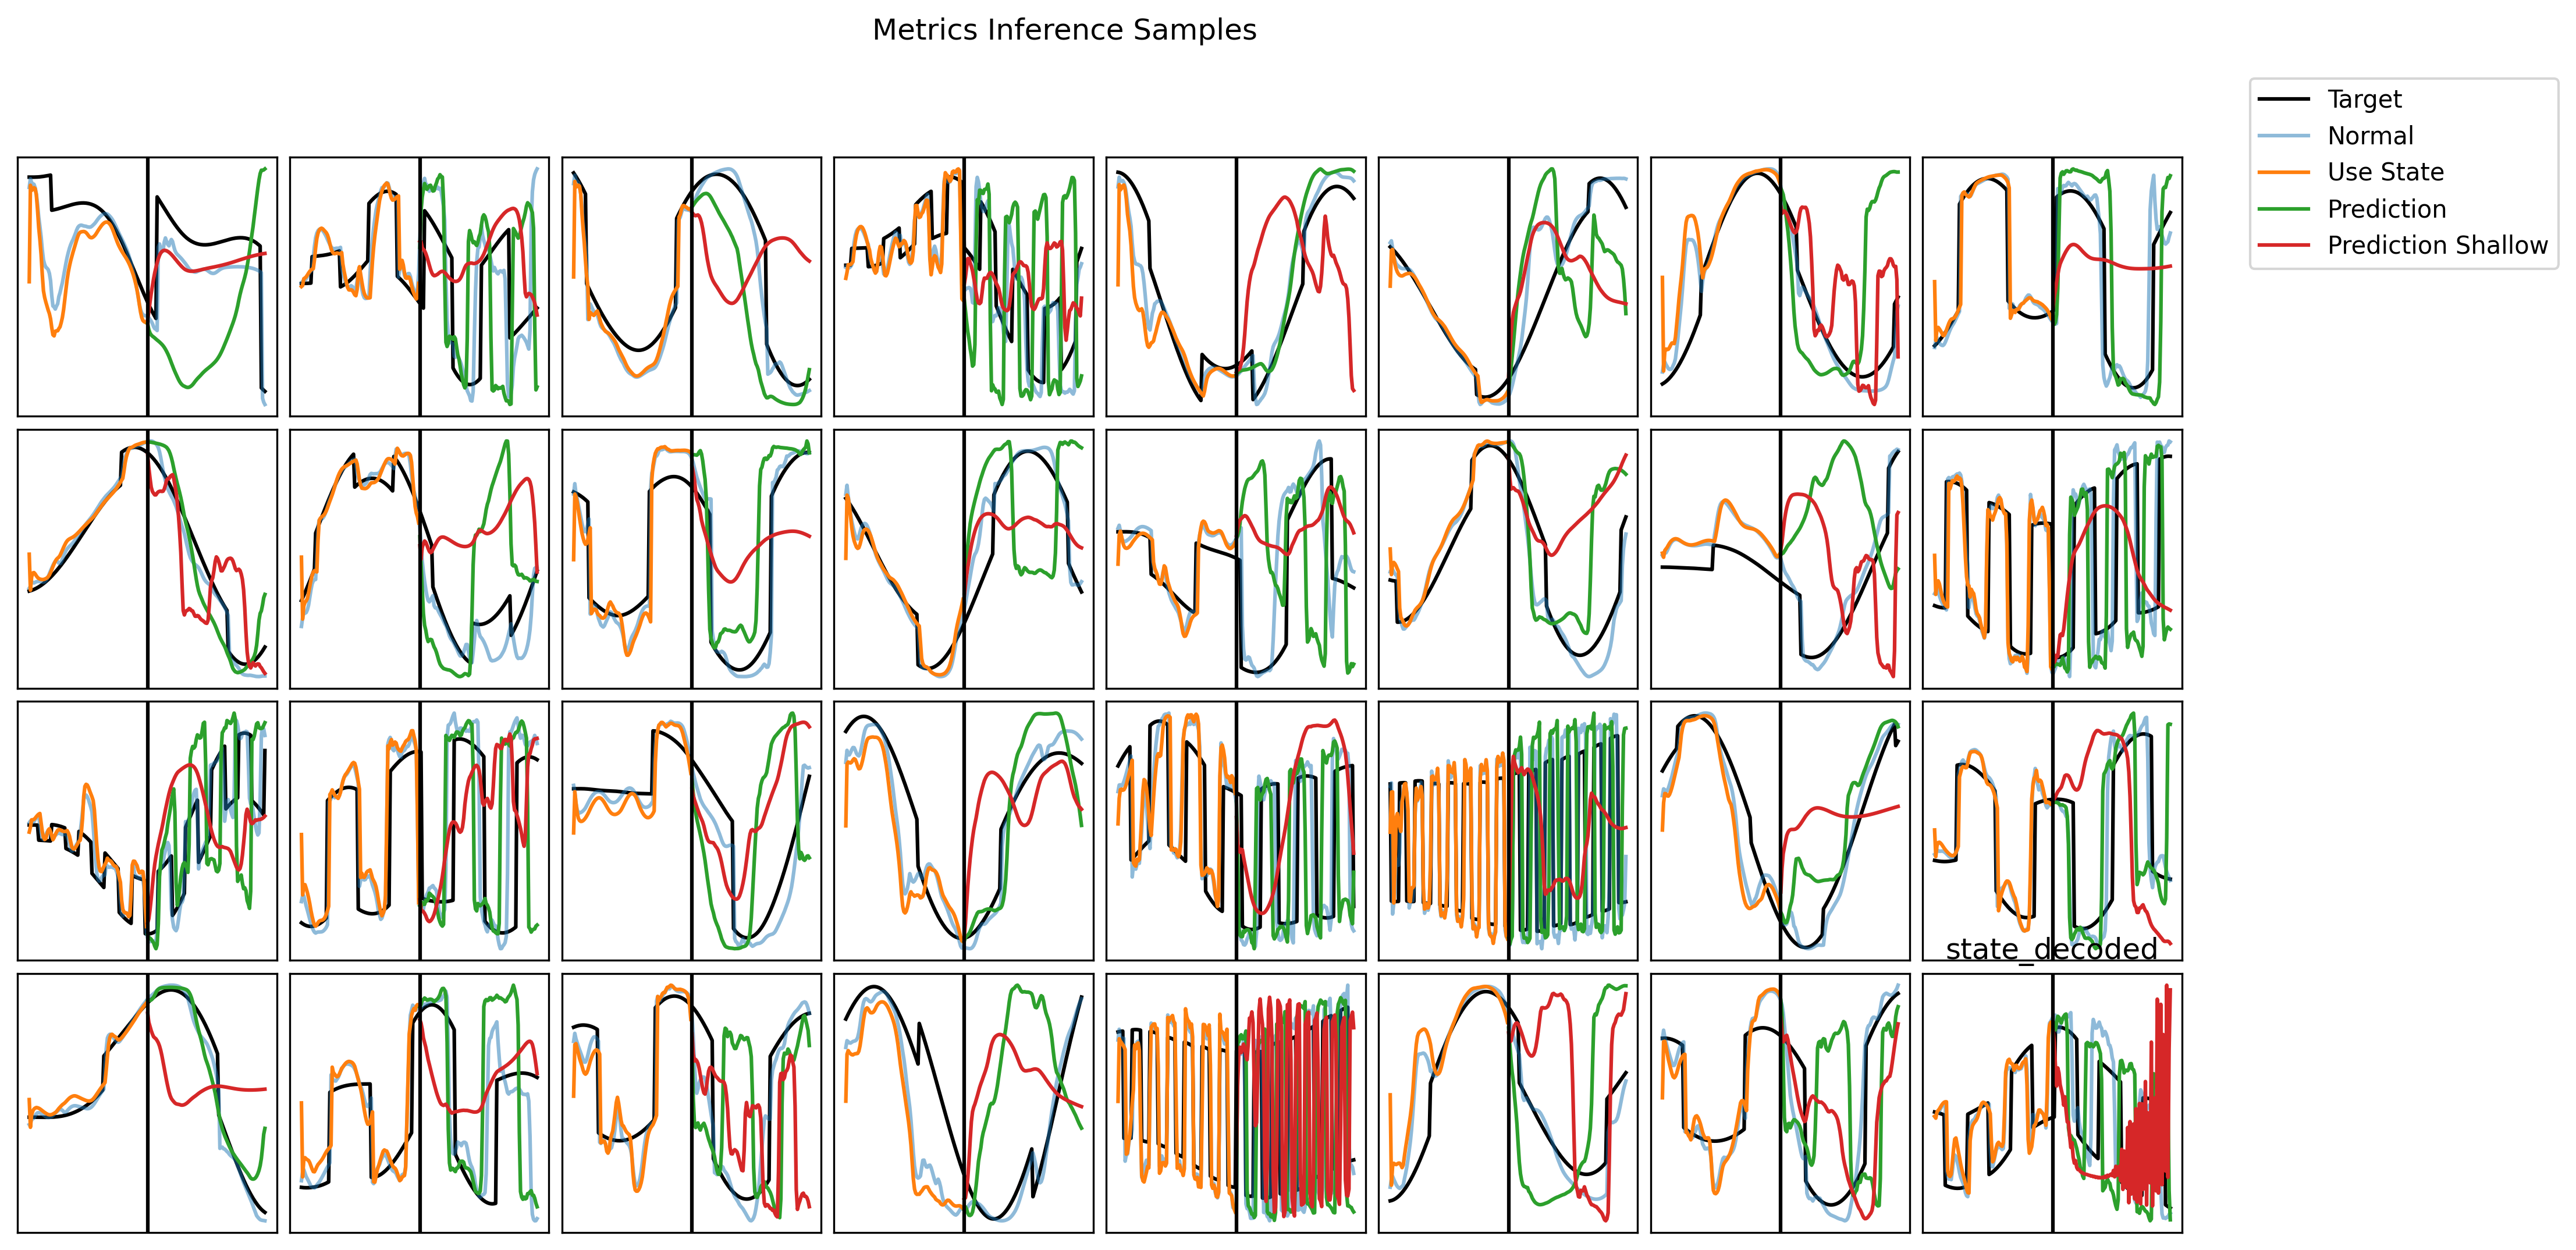

In [31]:
sample_plots = toy1d_metrics_sample_plots(sample_logits, skip_names=["state", "state_input", "state_control", "measurement"])

In [32]:
metrics = toy1d_metrics(model, dataloaders, criterion_set)

Metrics Generation: 100%|██████████| 250/250 [09:03<00:00,  2.17s/it]


In [34]:
from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
orig_metrics = load_multiple_metrics("toy1d_experiments/toy1d_experiment1_configuration_test", "toy1d_metrics")

In [35]:
orig_metrics_var = orig_metrics["variation169039990650476837415612865146336274566"]

In [37]:
orig_metrics_var["means"]

{'normal': {'state_decoded_mse': 0.005745531525462866,
  'state_decoded_0.1sdtw': 0.049730513244867325,
  'measurement_mse': 0.0031138439662754536,
  'measurement_0.1sdtw': 0.03741569444537163,
  'optimizer_loss': 0.004429687280207872},
 'use_state': {'state_decoded_mse': 0.009278137236833572,
  'state_decoded_0.1sdtw': 0.04497543349862099,
  'measurement_mse': 0.005326921585947275,
  'measurement_0.1sdtw': 0.03941391780972481,
  'optimizer_loss': 0.00730252917855978},
 'prediction': {'state_decoded_mse': 0.038888320326805115,
  'state_decoded_0.1sdtw': 0.14090374112129211,
  'measurement_mse': 0.02607259713113308,
  'measurement_0.1sdtw': 0.17161616683006287,
  'optimizer_loss': 0.03248045966029167},
 'prediction_shallow': {'state_decoded_mse': 0.18497686088085175,
  'state_decoded_0.1sdtw': 1.0416010618209839,
  'measurement_mse': 0.1196795180439949,
  'measurement_0.1sdtw': 1.309909701347351,
  'optimizer_loss': 0.15232817828655243}}

In [38]:
metrics

{'normal': {'state_decoded_mse': 0.027041437104344368,
  'measurement_mse': 0.016466913744807243,
  'optimizer_loss': 0.021754175424575806},
 'use_state': {'state_decoded_mse': 0.024210166186094284,
  'measurement_mse': 0.015180505812168121,
  'optimizer_loss': 0.019695337861776352},
 'prediction': {'state_decoded_mse': 0.1684352308511734,
  'measurement_mse': 0.11146551370620728,
  'optimizer_loss': 0.13995037972927094},
 'prediction_shallow': {'state_decoded_mse': 0.1637730598449707,
  'measurement_mse': 0.10407361388206482,
  'optimizer_loss': 0.13392327725887299}}

In [45]:
for task in ["normal", "use_state", "prediction", "prediction_shallow"]:
    m_task = metrics[task]["state_decoded_mse"]
    m_task_orig = orig_metrics_var["means"][task]["state_decoded_mse"]
    diff = (m_task-m_task_orig)/m_task_orig
    
    print(task, metrics[task]["state_decoded_mse"], orig_metrics_var["means"][task]["state_decoded_mse"], 100*diff, sep="|")

normal|0.027041437104344368|0.005745531525462866|370.65161829680994
use_state|0.024210166186094284|0.009278137236833572|160.9377892146451
prediction|0.1684352308511734|0.038888320326805115|333.12549741335476
prediction_shallow|0.1637730598449707|0.18497686088085175|-11.46294781677528


Task|Post-train|Origin|% Diff
-|-|-|-
normal|0.027041437104344368|0.005745531525462866|370.65161829680994
use_state|0.024210166186094284|0.009278137236833572|160.9377892146451
prediction|0.1684352308511734|0.038888320326805115|333.12549741335476
prediction_shallow|0.1637730598449707|0.18497686088085175|-11.46294781677528